<font size=5>
  Manuel Weitzman 201473501-4 --- Andrés Huerta 201473544-8
  </font>

In [1]:
#csv desde drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import keras as keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import heapq as hq
from keras import backend as K

from keras.models import Model, Sequential
from keras.layers import Input, Dense, LSTM, GRU, Dropout, RepeatVector, CuDNNGRU, Conv1D, Flatten, SimpleRNN, Bidirectional
from keras.optimizers import Adam, SGD

from sklearn.metrics import mean_squared_error
import math

Using TensorFlow backend.


Se generan funciones para determinar que dias corresponder a cyber days.

In [0]:
more_days = [1, 3, 5, 6, 7, 9, 12]

def sum_day(day, month, year):
    day = day + 1
    if day == 29:
        if month == 2:
            day = 1
            month += 1
    elif day == 31:
        if month not in more_days:
            day = 1
            month += 1
    elif day == 32:
        if month == 12:
            day = 1
            month = 1
            year += 1
        else:
            day = 1
            month += 1
    
    return [day, month, year]
  
def in_sale(day, month, year):
    if year == 2017:
        if month == 5:
            if day in [29, 30, 31]:
                return 1
        if month == 11:
            if day in [6, 7, 8]:
                return 1
    if year == 2018:
        if month == 5:
            if day in [28, 29, 30]:
                return 1
        if month == 10:
            if day in [8, 9, 10]:
                return 1
    return 0

In [0]:
D = dict()

with open('drive/My Drive/Colab Notebooks/costanera2.csv', 'r') as istream:
    for line in istream:
        if line == '\n': continue
        for tup in line.split(';'):
            id_prod, y, z = tuple(map(int, tup.split(',')))
            if id_prod not in D:
                D[id_prod] = [0,0,0]
            D[id_prod][0] += 1 #days sold
            D[id_prod][1] += y #count
            D[id_prod][2] += z #money

La regresion siempre se realizara a los primeros 4 elementos mas vendidos, en caso de querer probar con mas items cambiar el parametro size (tiene que ser 4 o mayor)

In [0]:
size = 4
bestest = hq.nlargest(size, D.items(), key=lambda x: x[1]) #The variable name is on porpuse

Luego, se seleccionan los 4 productos mas vendidos a lo largo de los dos años de datos.

In [6]:
#Notice that there's a peak at the end, that could mean that during that time there was a special offer like a cyberday
#It could be a good idea to create a feature that determines if we are on a sale day or not (1 or 0)

values = list()
day_counter = 0

items = [x[0] for x in bestest]#most sold{4385959, 168757, 2678016, 4695904}, switch data {5556543, 5686606, 5621240, 5605572}
items_data = {item: [0, 0] for item in items}
day_number, month, year = 31, 1, 2017 #30 days laters

#day_number, month, year = 1, 1, 2017
#Most selled items ids 4385959, 168757, 2678016, 4695904
#We create our dataset by saving 2 values, times bought in the day and how much did we earn from it
with open('drive/My Drive/Colab Notebooks/costanera2.csv', 'r') as istream:
    for line in istream:
        if line == '\n': continue
        day = list()
        for tup in line.split(';'):
            id_prod, y, z = tuple(map(int, tup.split(',')))
            #Instead of just looking for 1 item, we need to do it for 4
            if id_prod in items:
                items_data[id_prod][0] += y
                items_data[id_prod][1] += z*y
        day.append(in_sale(day_number, month, year))
        for item in items:
            day.append(items_data[item][0])
            day.append(items_data[item][1])
        values.append(day)
        items_data = {item: [0, 0] for item in items}
        date = sum_day(day_number, month, year)
        day_number = date[0]
        month = date[1]
        year = date[2]

cols = ['sale']
for i in range(len(bestest)):
    cols.append('count'+str(i))
    cols.append('money'+str(i))    

#We save our data into a dataframe to easily manage it                
df = pd.DataFrame(data=np.asarray(values), columns=cols, dtype='float32')
df.head()

,sale,count0,money0,count1,money1,count2,money2,count3,money3
0,0.0,264.0,48048.0,45.0,598140.0,9.0,1165995.0,13.0,38714.0
1,0.0,264.0,29304.0,43.0,519010.0,3.0,189000.0,5.0,14950.0
2,0.0,273.0,45045.0,72.0,974376.0,6.0,552996.0,6.0,17940.0
3,0.0,273.0,56784.0,60.0,780600.0,5.0,269000.0,3.0,8970.0
4,0.0,293.0,143863.0,83.0,1024303.0,0.0,0.0,5.0,14950.0


Es necesario destacar un dato muy importante al momento de realizar esto, dado que los productos solo se seleccionaron por su frecuencia de compras y no por su relación es posible que los datos que aparescan en el dataset no tengan ningún tipo de asociación lo que al final significara un ruido para el modelo al momento de entrenar, se intento buscar productos relacionados entre si, pero la cantidad de productos que posee falabella es muy extensa y su variedad a veces puede significar que se tiene menos registros de ventas. Ademas de probar con los productos seleccionados se intento con familiar de productos como por ejemplo ropa de mujer, zapatos, calcetines etc, o con nintendo switch + joycon + bolso generico + algun juego, pero la cantidad de ventas realizadas eran muy pocas por lo que el modelo tendia a predecir solo 0.

Se muestran los boxplots de cada atributo guardado en el dataset, estos corresponden a cantidad del producto x vendida y cantidad de dinero ganado en promedio al dia por dicho producto ademas de un atributo que determina si se encuentran en cyberdays o no.

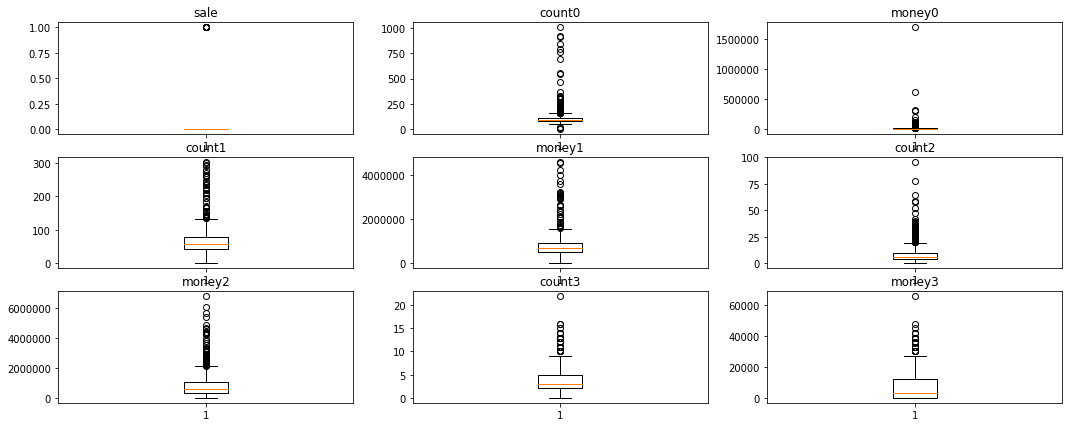

In [7]:
columns_names = df.columns.values
plt.figure(figsize=(18, 7))

for i in range(len(columns_names)):
    plt.subplot(3, 3, i+1)
    plt.boxplot(df[columns_names[i]].values)
    plt.title(columns_names[i])
    
plt.show()

Se separan los conjuntos entre datos para entrenamiento y datos para validación.

In [8]:
#We separate our data into train and test data
#500 days will be for training and 215 for testing
trainData = df[:635]
testData = df[635:]

print(len(trainData), len(testData))

635 80


Se opta por utilizar un escalador estandard porque se asume que el modelo logre determinar las ventas que se esperan para dias como cyberdays.

In [0]:
#Dropping money cause we wont use it in this example (but it could be used)
#trainData = trainData.drop(['money0', 'money1', 'money2', 'money3'], axis=1)
#testData = testData.drop(['money0', 'money1', 'money2', 'money3'], axis=1)

#trainData = trainData.drop(['money0', 'count1', 'count2', 'count3', 'money1', 'money2', 'money3'], axis=1)
#testData = testData.drop(['money0', 'count1', 'count2', 'count3', 'money1', 'money2', 'money3'], axis=1)

drop_money = list()
for i in range(len(bestest)):
    drop_money.append('money'+str(i))

trainData = trainData.drop(drop_money, axis=1)
testData = testData.drop(drop_money, axis=1)

    
forPreds = trainData.copy()
forPreds = forPreds[['count0', 'count1', 'count2', 'count3']]

#forPreds = forPreds.drop(['sale', 'money0', 'money1', 'money2', 'money3'], axis=1)
#forPreds = forPreds.drop(['sale'], axis=1)
#forPreds = forPreds.drop(['sale', 'count4', 'count5', 'count6', 'count7', 'count8', 'count9'], axis=1)

In [0]:
from sklearn.preprocessing import StandardScaler, RobustScaler

#Scaling our values (including this must includes the values that will be in the 'y' dataset)
scaler = StandardScaler()
scaler.fit(trainData)

scaler2 = StandardScaler()
scaler2.fit(forPreds)

train_data_scaled = scaler.transform(trainData)
test_data_scaled = scaler.transform(testData)

Se genera una función para obtener las series de tiempo a utilizar en los modelos.

In [0]:
#Here is were we create our dataset
#X will have a lag of 20 days, meaning that it will contain (in separate features) how many items of product 0 were sold in the day
#Y will have just 1 value (1 per item) where it will contain how many items of product were sold in 30 days after the final day of X

#This should look like this with a lag of 3
# [x            | y ]
# [13   30    12| 20]
# [30   12    11| 23]

#Notice that after 30 days have passed the first value of X will be y[0] = 20
def create_dataset(dataset, lag=3):
    #This is to know which entry will be the last one able to be saved
    max_y = len(dataset) - 30
    counter = 1
    y_list, x_list = list(), list()
    temp = list()
    
    for row in range(max_y):
        #Once this condition is accepted then we will start adding our data to the dataset
        if counter > lag:
            #y_list.append(dataset[row + 30][1:]) #append the quantity of items sold after 30 days
            #y_list.append([dataset[row + 30][1], dataset[row + 30][3], dataset[row + 30][5], dataset[row + 30][7]])
            y_list.append(dataset[row + 30][1:5])
            x_list.append(np.array(temp))
            temp.pop(0)
        #We create a temp list that will contain the values of X
        temp.append(dataset[row])
        counter += 1
    
    return np.array(x_list), np.array(y_list) #Return Xdata and Ydata

Se define un lag de 3 timestamps, en caso de elegir más la tasa de aprendizaje es muy lenta.

In [0]:
laag = 5
X_train, y_train = create_dataset(train_data_scaled, laag)
X_test, y_test = create_dataset(test_data_scaled, laag)

In [13]:
X_train.shape, y_train.shape

((600, 5, 5), (600, 4))

Se utiliza ademas la función de perdida pinball error, aunque quizas el contexto del problema no sea el mas adecuado para su utilización fue la función de perdidas que mejor curva de aprendizaje y resultados obtuvo.

In [0]:
def pinball(tau = 0.5):
    def loss(y_true, y_pred):
        err = y_true - y_pred
        return K.mean(K.maximum(tau * err, (tau - 1) * err), axis=-1)
    return loss

pinball_loss = pinball(0.5)

Se define una función para ver las curvas de aprendizaje y validación (en este caso testing dado que no se contaba con una gran cantidad de datos).

In [0]:
def plot_losses(hist): 
    plt.figure(figsize=(15, 7))
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Train Loss", "Val Loss"], loc="upper right")
    plt.title("Traning & Test Losses")
    plt.show()
    print("Final Train Loss:",hist.history['loss'][-1])
    print("Final Test Loss:",hist.history['val_loss'][-1])

Se utiliza una función para mostrar las predicciones vs los valores reales de cada producto predecido.

In [0]:
#And we plot our values
def plot_predictions(model, X_test, y_test):
    #We predict and after that descale our data (remember it was scaled before)
    y_pred = model.predict(X_test)
    y_true = y_test
    y_pred = scaler2.inverse_transform(y_pred)
    y_true = scaler2.inverse_transform(y_true)
    
    plt.figure(figsize=(18,10))
    
    for i in range(len(y_true[0])):
        plt.subplot(2,2,i+1)
        plt.title("Ventas producto: "+str(i))
        plt.plot([x[i] for x in y_pred], '-o')
        plt.plot([x[i] for x in y_true], '-o')
        plt.legend(['Predicted', 'True'])

    plt.show()

In [0]:
def rmse_f(model, X_test, y_true):
    y_pred = model.predict(X_test)
    
    mses = mean_squared_error(y_true, y_pred, multioutput='raw_values')
    rmses = [math.sqrt(x) for x in mses]
    rmses.append(math.sqrt(mean_squared_error(y_true, y_pred)))

    return rmses

## Modelos

El primer modelo corresponde a una red que cuenta con una sola capa LSTM y una capa densa, se probo la efectividad del modelo utilizando LSTM, SimpleRNN y GRU y fue la utilizada la que obtuvo mejores desempeños.

In [18]:
#Our model, it needs to be improved
#Input shape -> Timestamps, features
model1 = Sequential()
model1.add(LSTM(units=128, input_shape=(laag, X_train.shape[2]), activation='tanh',return_sequences=False,go_backwards=False)) #128
model1.add(Dense(4,activation='linear'))
model1.compile(loss=pinball_loss, optimizer='adam') #0.8
model1.summary()

W0805 21:26:04.045674 140071889295232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0805 21:26:04.067327 140071889295232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0805 21:26:04.074988 140071889295232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0805 21:26:04.359595 140071889295232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               68608     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
Total params: 69,124
Trainable params: 69,124
Non-trainable params: 0
_________________________________________________________________


In [19]:
history1 = model1.fit(X_train, y_train, epochs=20, batch_size=5, validation_data=(X_test, y_test), verbose=0)

W0805 21:26:04.530828 140071889295232 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0805 21:26:05.209566 140071889295232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0805 21:26:05.309272 140071889295232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



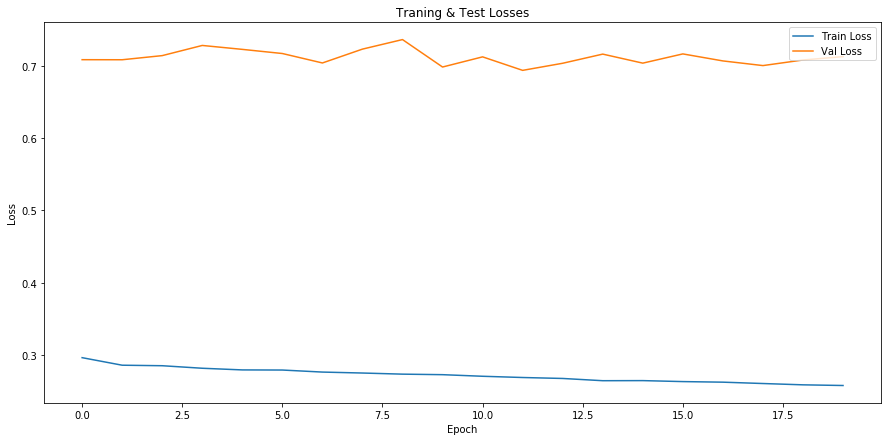

Final Train Loss: 0.2576769324019551
Final Test Loss: 0.712673952182134


In [20]:
plot_losses(history1)

Se puede notar que a medida que avanzan los epochs, la red no logra obtener un desempeño en aumento para el conjunto de pruebas.

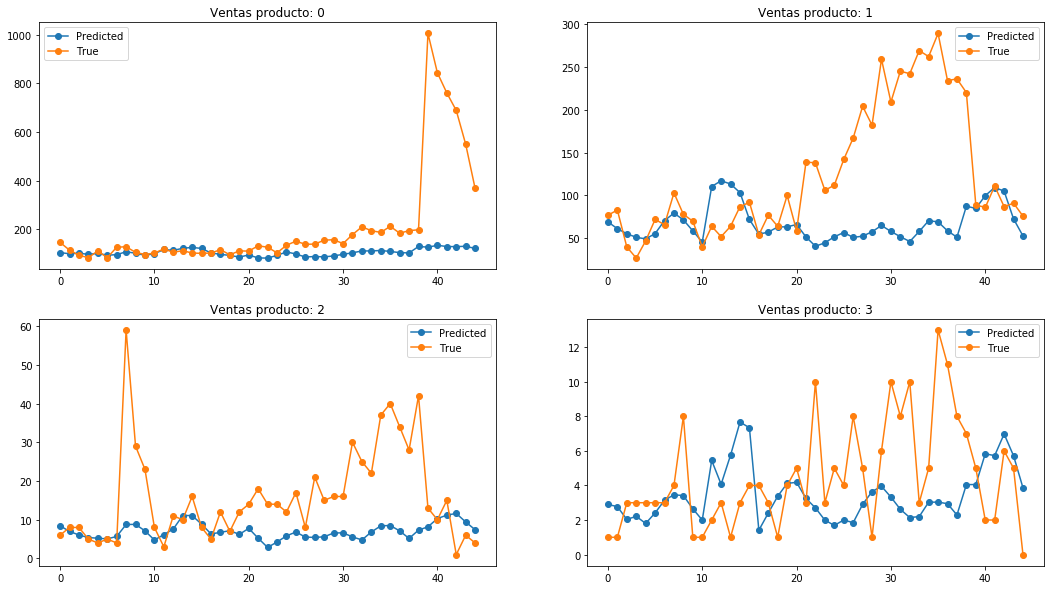

In [21]:
plot_predictions(model1, X_test, y_test)

Observando los valores predichos y reales se identifica que la red obtuvo los mejores desempeños al predecir los productos 0 y 2 ubicados en la primera columna, pero el resto de las predicciones no lograron obtener valores deseables.

In [22]:
rmses1 = rmse_f(model1, X_test, y_test)
print("Modelo 1:")
print("RMSE producto 0:",rmses1[0])
print("RMSE producto 1:",rmses1[1])
print("RMSE producto 2:",rmses1[2])
print("RMSE producto 3:",rmses1[3])
print("RMSE general:   ",rmses1[4])

Modelo 1:
RMSE producto 0: 3.1408457216619996
RMSE producto 1: 2.7402827260589886
RMSE producto 2: 1.9236232675002494
RMSE producto 3: 1.2913816748082219
RMSE general:    2.3844315030693686


## Modificación

Se agrega una capa densa con activación relu antes de la capa de salida para ver si existe alguna mejora en el desempeño del modelo.

In [23]:
model3 = Sequential()
model3.add(LSTM(units=128, input_shape=(laag, X_train.shape[2]), activation='tanh', return_sequences=False))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(units=4, activation='linear'))
model3.compile(loss=pinball_loss, optimizer='adam')
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               68608     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 77,124
Trainable params: 77,124
Non-trainable params: 0
_________________________________________________________________


In [0]:
history3 = model3.fit(X_train, y_train, epochs=20, batch_size=5, validation_data=(X_test, y_test), verbose=0)

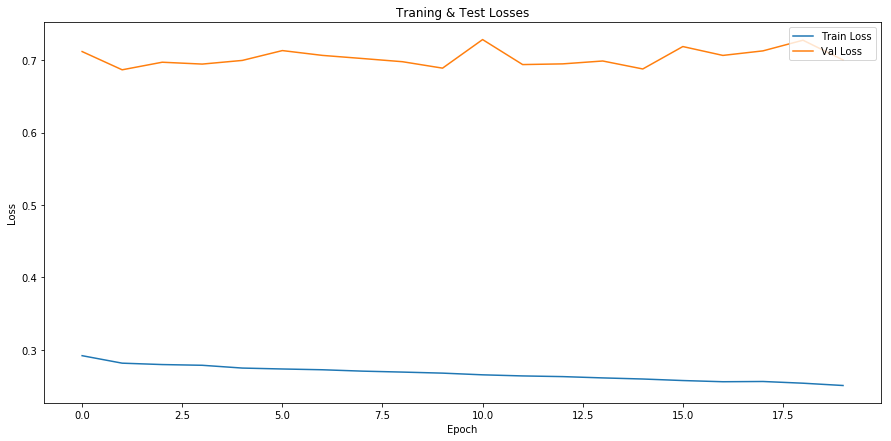

Final Train Loss: 0.2508438526963194
Final Test Loss: 0.700196666849984


In [25]:
plot_losses(history3)

Nuevamente se obtiene un resultado con una baja tasa de aprendizaje, pero con un error de pruebas un tanto mejor que el modelo anterior.

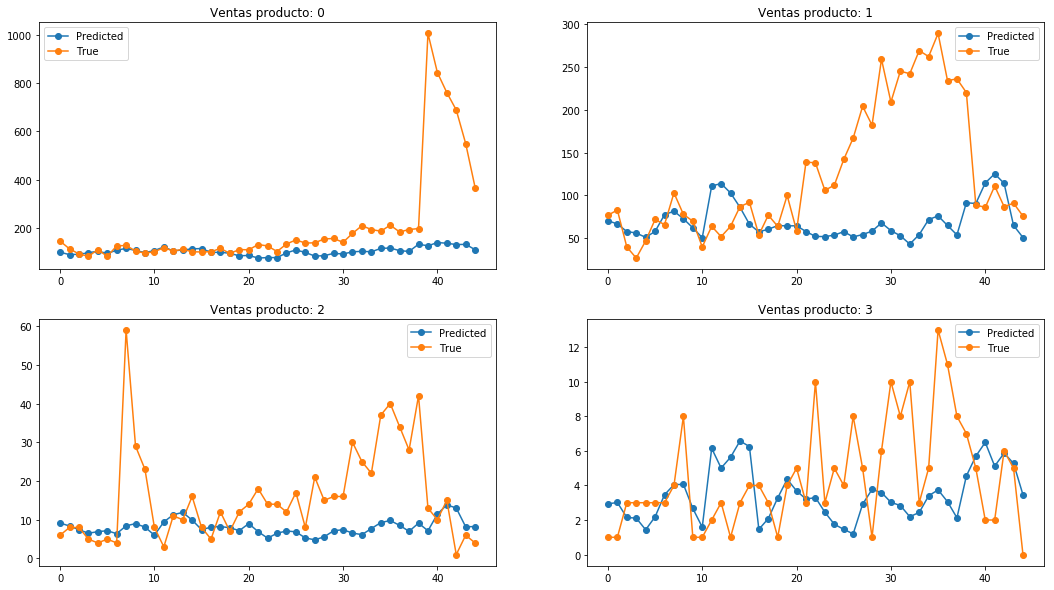

In [26]:
plot_predictions(model3, X_test, y_test)

Para este caso, se logra notar que por lo menos el tercer cuadro logra mejorar la predicción en comparación al modelo anterior, cabe destacar que la fecha que se predice en ese punto corresponde a uno de los dias cyberdays, por lo que la red fue capaz de predecir un tanto mejor las ventas de dichas fechas.

In [27]:
rmses3 = rmse_f(model3, X_test, y_test)
print("Modelo 2:")
print("RMSE producto 0:",rmses3[0])
print("RMSE producto 1:",rmses3[1])
print("RMSE producto 2:",rmses3[2])
print("RMSE producto 3:",rmses3[3])
print("RMSE general:   ",rmses3[4])

Modelo 2:
RMSE producto 0: 3.126059666884298
RMSE producto 1: 2.70348717889168
RMSE producto 2: 1.8622225579141942
RMSE producto 3: 1.262710741409208
RMSE general:    2.3528388830850244


## Convolucional 1D

Para intentar mejorar el desempeño se utiliza una capa de entrada convolucional 1D para intentar determinar caracteristicas relevantes sobre el conjunto.

In [28]:
model5 = Sequential()
model5.add(Conv1D(32, kernel_size=2, input_shape=(laag, X_train.shape[2]), activation='relu', padding='valid')) # or kernel=2
gate_layer = LSTM(units=128, activation='tanh', return_sequences=False)
model5.add(Bidirectional(gate_layer, merge_mode='mul'))

model5.add(Dense(4, activation='linear'))
model5.compile(loss=pinball_loss, optimizer='adam')
model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 4, 32)             352       
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               164864    
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 516       
Total params: 165,732
Trainable params: 165,732
Non-trainable params: 0
_________________________________________________________________


In [0]:
history5 = model5.fit(X_train, y_train, epochs=20, batch_size=5, validation_data=(X_test, y_test), verbose=0)

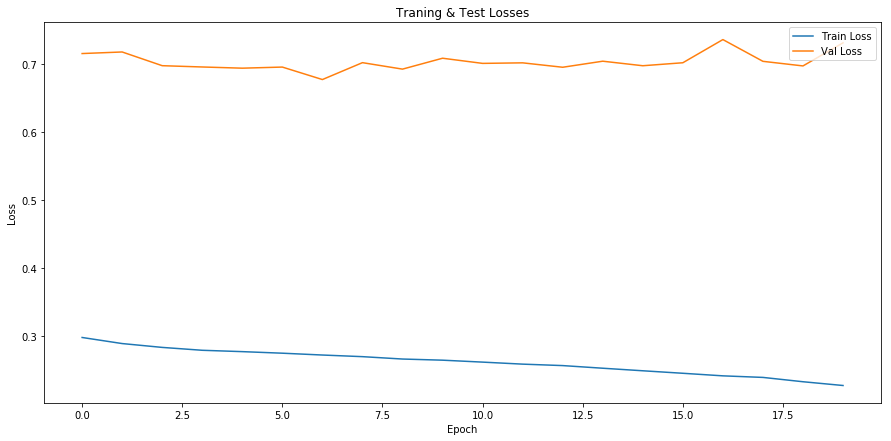

Final Train Loss: 0.2272519912570715
Final Test Loss: 0.7310160977972878


In [30]:
plot_losses(history5)

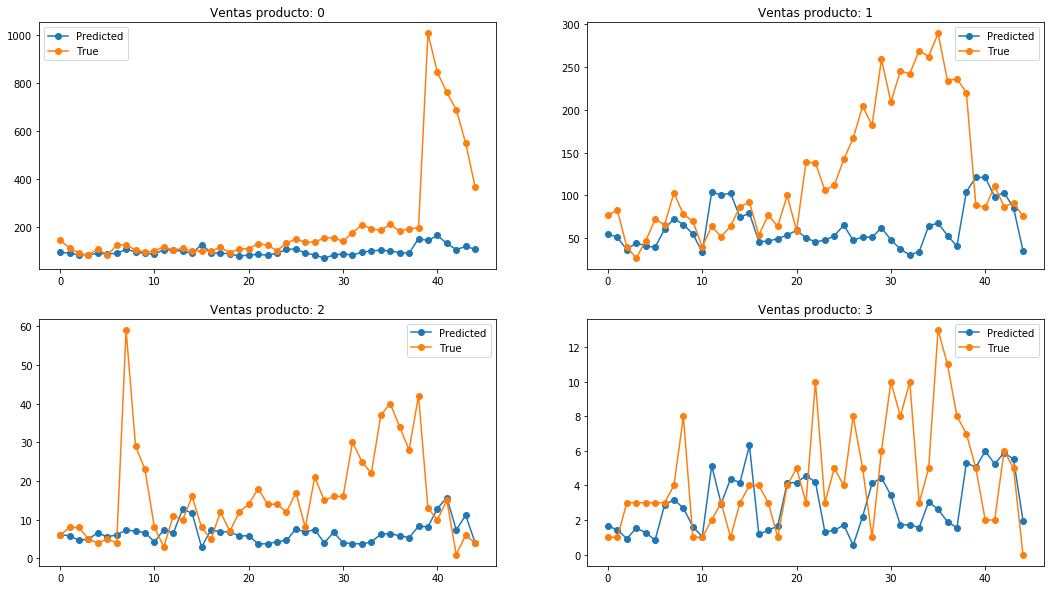

In [31]:
plot_predictions(model5, X_test, y_test)

En los 3 modelos que se han analizado hasta ahora se puede ver una similitud de las predicciones realizadas en el segundo gráfico.

In [32]:
rmses5 = rmse_f(model5, X_test, y_test)
print("Modelo 3:")
print("RMSE producto 0:",rmses5[0])
print("RMSE producto 1:",rmses5[1])
print("RMSE producto 2:",rmses5[2])
print("RMSE producto 3:",rmses5[3])
print("RMSE general:   ",rmses5[4])

Modelo 3:
RMSE producto 0: 3.1215723034275413
RMSE producto 1: 2.8427689442933493
RMSE producto 2: 1.9953581764082533
RMSE producto 3: 1.299803953713328
RMSE general:    2.4236590873312154


## 2 Capas recurrentes

In [33]:
model6 = Sequential()
model6.add(LSTM(units=128, input_shape=(laag, X_train.shape[2]), activation='tanh',return_sequences=False, go_backwards=True))
model6.add(Dense(4,activation='linear'))
model6.compile(loss=pinball_loss, optimizer='adam')
model6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 128)               68608     
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 516       
Total params: 69,124
Trainable params: 69,124
Non-trainable params: 0
_________________________________________________________________


In [0]:
history6 = model6.fit(X_train, y_train, epochs=20, batch_size=5, validation_data=(X_test, y_test), verbose=0)

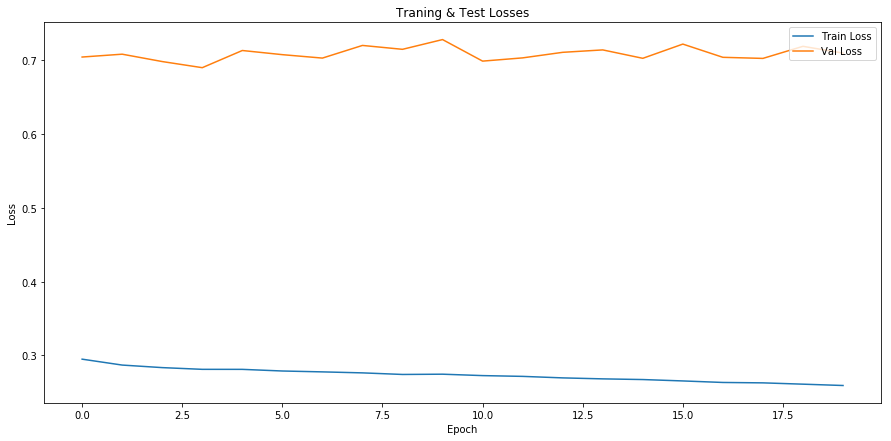

Final Train Loss: 0.2591849667330583
Final Test Loss: 0.7097168564796448


In [35]:
plot_losses(history6)

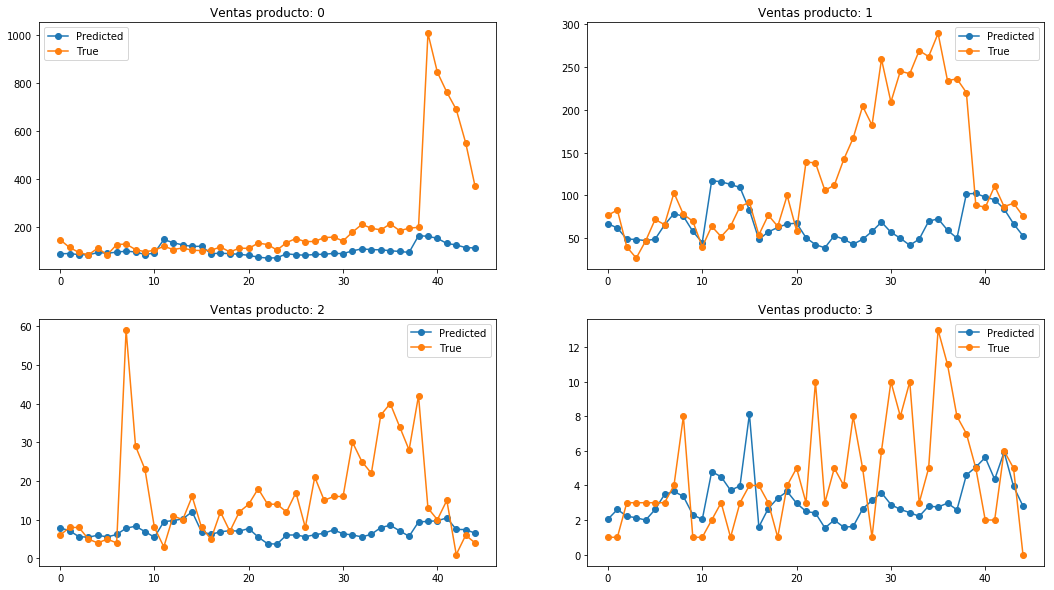

In [36]:
plot_predictions(model6, X_test, y_test)

In [37]:
rmses6 = rmse_f(model6, X_test, y_test)
print("Modelo 4:")
print("RMSE producto 0:",rmses6[0])
print("RMSE producto 1:",rmses6[1])
print("RMSE producto 2:",rmses6[2])
print("RMSE producto 3:",rmses6[3])
print("RMSE general:   ",rmses6[4])

Modelo 4:
RMSE producto 0: 3.110197744968001
RMSE producto 1: 2.7569502089615043
RMSE producto 2: 1.904506452185312
RMSE producto 3: 1.2459675610217216
RMSE general:    2.369265944181384


## Modelo convolucional

Finalmente se utiliza una red como la presentada en la tarea anterior.

In [38]:
modelf = Sequential()
modelf.add(Conv1D(32, kernel_size=1, input_shape=(laag, X_train.shape[2]), activation='relu',padding='valid')) 
modelf.add(Flatten())
modelf.add(Dense(4,activation='linear'))
modelf.compile(loss=pinball_loss, optimizer='adam')
modelf.summary()
cnn_weights = modelf.get_weights()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 5, 32)             192       
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 644       
Total params: 836
Trainable params: 836
Non-trainable params: 0
_________________________________________________________________


In [0]:
historyf = modelf.fit(X_train, y_train, epochs=20, batch_size=5, verbose=0, validation_data=(X_test, y_test))

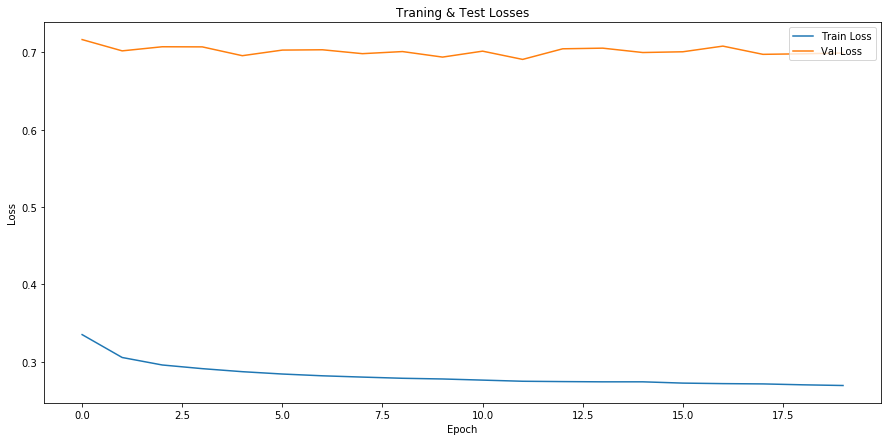

Final Train Loss: 0.2691827183589339
Final Test Loss: 0.6991907954216003


In [40]:
plot_losses(historyf)

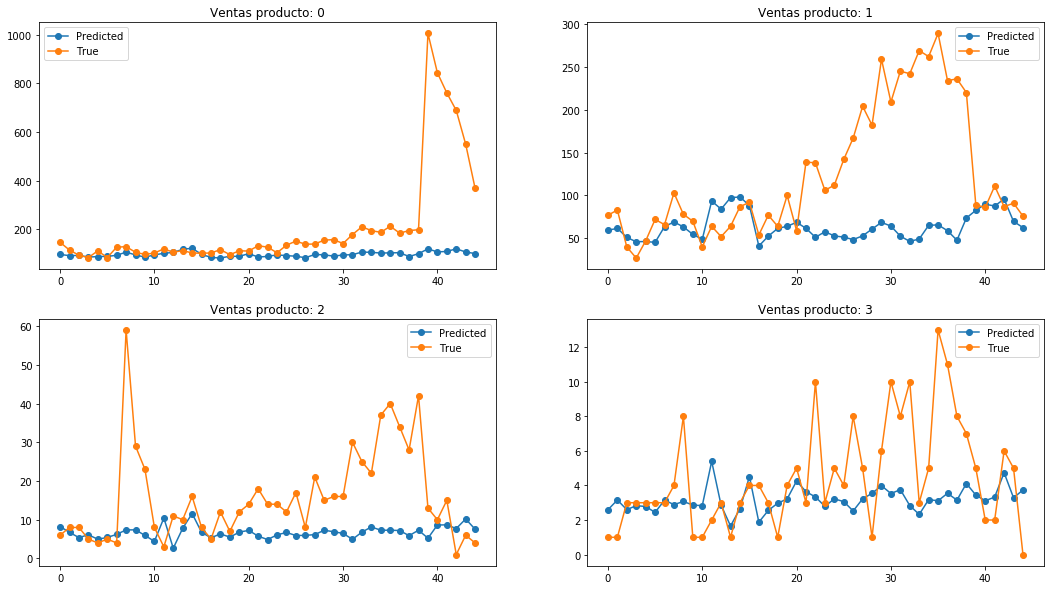

In [41]:
plot_predictions(modelf, X_test, y_test)

In [42]:
rmsesf = rmse_f(modelf, X_test, y_test)
print("Modelo F:")
print("RMSE producto 0:",rmsesf[0])
print("RMSE producto 1:",rmsesf[1])
print("RMSE producto 2:",rmsesf[2])
print("RMSE producto 3:",rmsesf[3])
print("RMSE general:   ",rmsesf[4])

Modelo F:
RMSE producto 0: 3.2327667433657528
RMSE producto 1: 2.7394073830599193
RMSE producto 2: 1.9472879806575156
RMSE producto 3: 1.1249101408672961
RMSE general:    2.39856659965979


In [43]:
print("RMSE Finales:")
print("RMSE modelo 1:",rmses1[4])
print("RMSE modelo 2:",rmses3[4])
print("RMSE modelo 3:",rmses5[4])
print("RMSE modelo 4:",rmses6[4])
print("RMSE modelo F:",rmsesf[4])

RMSE Finales:
RMSE modelo 1: 2.3844315030693686
RMSE modelo 2: 2.3528388830850244
RMSE modelo 3: 2.4236590873312154
RMSE modelo 4: 2.369265944181384
RMSE modelo F: 2.39856659965979


En general no fue posible obtener resultados realmente buenos, probablemente es necesario obtener atributos mas importantes y obtener una verdadera relación entre productos, dado que se obtienen solo los primero 4 mas vendidos comparados con la cantidad de productos existentes esmuy probable que estos productos no tengan relación entre ellos.